# Postprocessing in the cloud

In order to generate training data, we are post processing the games in the cloud. This consists of a few steps:
- determine the ball position
- use this to score the frames
- use the scored frames to train a neural network using reinforcement learning



# Loading an image from saved game data

The following illustrates how to load an image from the saved game data. The frames are saved in a HDF5 file encoded as jpgs. The HDF5 file contains further metadata.

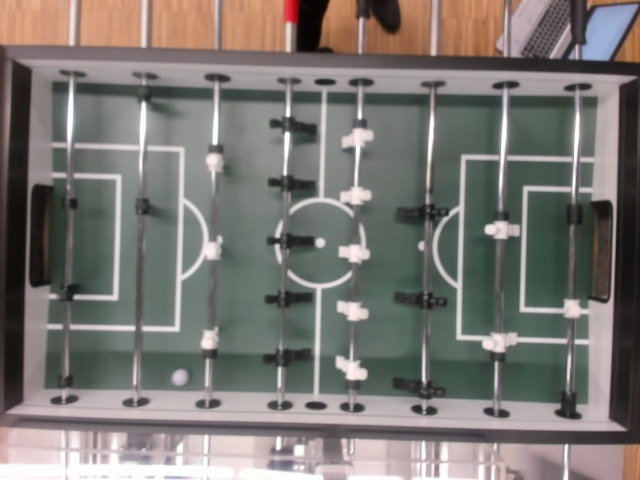

In [24]:
import cv2
import h5py
import numpy as np
from PIL import Image

file = h5py.File('../train/Fabian_20180308_080924.h5')
game = file['game20']
frame = game['frames'][60]

b = bytearray()
b.extend(frame)

image = cv2.imdecode(np.array(b), cv2.IMREAD_COLOR)
Image.fromarray(image[:,:,::-1])

# Extracting the playing field

The following routine is used to extract the playing field from the captured image.

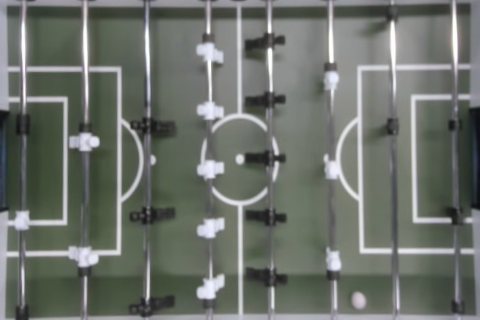

In [49]:
from kicker.image import Analyzer
import yaml

with open('../config.yml', 'r') as f:
    config =  yaml.load(f)
    
analyzer = Analyzer(config)
field = analyzer.extract_table(image, (320, 480))
field = np.swapaxes(field, 1, 0).astype(np.uint8)

Image.fromarray(field)

# Locating the ball

A neural net is used to determine the ball position. This neural net has been trained using supervised learning and hand labeled data witha ball position.

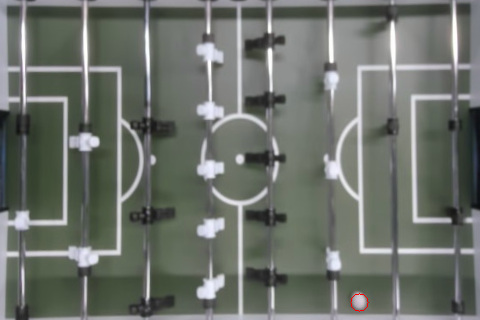

In [55]:
import tensorflow as tf

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile('../tools/frozen_inference_graph.pb', 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(graph=detection_graph, config=config) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        image_np_expanded = np.expand_dims(field, axis=0)

        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})

        x_middle = int(round(0.5 * (boxes[0][0][1] * 480 + boxes[0][0][3] * 480)))
        y_middle = int(round(0.5 * (boxes[0][0][0] * 320 + boxes[0][0][2] * 320)))
        
Image.fromarray(cv2.circle(field.copy(), (x_middle, y_middle), 9, (255, 0, 0)))